<a href="https://colab.research.google.com/github/NeelayS/gnss/blob/master/VTEC_FF%2BLSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Time series forecasting

In [ ]:
import tensorflow as tf
tf.random.set_seed(13)
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

# Get data

from google.colab import drive
drive.mount('/gdrive')
project_path = '/gdrive/My Drive/GNSS/'
train_df = pd.read_csv(project_path + 'data/dataset_IISC_2009_2018.csv') 
test_df = pd.read_csv(project_path + 'data/dataset_IISC_2019_only.csv')
df = train_df.append(test_df, ignore_index=True)

# Consider only certain features and make DOY and HR continous using sin and cos

input_df = df[['Year','DOY','HR','Dst','Ap','f10.7','Vtec', 'ROTI']]
input_df['DOYs'] = np.sin((2*np.pi*input_df['DOY'].values)/365.25)
input_df['DOYc'] = np.cos((2*np.pi*input_df['DOY'].values)/365.25)
input_df['HRs'] = np.sin((2*np.pi*input_df['HR'].values)/24)
input_df['HRc'] = np.cos((2*np.pi*input_df['HR'].values)/24)
input_df_features = input_df[['DOYs', 'DOYc', 'HRs', 'HRc', 'Dst', 'Ap', 'f10.7', 'Vtec', 'ROTI']]
input_df_years = input_df['Year']


# scale features
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(-1, 1))
input_df_features_scaled = pd.DataFrame(scaler.fit_transform(input_df_features), columns=input_df_features.columns)
input_df_features_scaled['Year'] = input_df_years
input_df = input_df_features_scaled[['Year', 'DOYs', 'DOYc', 'HRs', 'HRc', 'Dst', 'Ap', 'f10.7', 'Vtec', 'ROTI']]
df = input_df.drop(columns=['Year'])

test_indices = list(input_df[input_df['Year'] == 2014].index)[54*24:100*24] # Get indices for 55th to 100th day in 2014

N = len(df)
print(df)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

           DOYs      DOYc       HRs  ...     f10.7      Vtec      ROTI
0      0.017209  0.999861  0.000000  ... -0.993166 -0.961946 -0.998437
1      0.017209  0.999861  0.258819  ... -0.993166 -0.876859 -0.998726
2      0.017209  0.999861  0.500000  ... -0.993166 -0.772374 -0.998278
3      0.017209  0.999861  0.707107  ... -0.993166 -0.717364 -0.998341
4      0.017209  0.999861  0.866025  ... -0.993166 -0.688455 -0.997542
...         ...       ...       ...  ...       ...       ...       ...
96403 -0.004294  1.000000 -0.965926  ... -0.989749 -0.910443 -0.998642
96404 -0.004294  1.000000 -0.866025  ... -0.989749 -0.922707 -0.997301
96405 -0.004294  1.000000 -0.707107  ... -0.989749 -0.919610 -0.996383
96406 -0.004294  1.000000 -0.500000  ... -0.989749 -0.925073 -0.991475
96407 -0.004294  1.000000 -0.258819  ... -0.989749 -0.950225 -0.993425

[96408 rows x 9 columns]


In [ ]:
df.head()

,DOYs,DOYc,HRs,HRc,Dst,Ap,f10.7,Vtec,ROTI
0,0.017209,0.999861,0.000000,1.000000,0.440000,-0.949153,-0.993166,-0.961946,-0.998437
1,0.017209,0.999861,0.258819,0.965926,0.453333,-0.949153,-0.993166,-0.876859,-0.998726
2,0.017209,0.999861,0.500000,0.866025,0.460000,-0.949153,-0.993166,-0.772374,-0.998278
3,0.017209,0.999861,0.707107,0.707107,0.453333,-0.923729,-0.993166,-0.717364,-0.998341
4,0.017209,0.999861,0.866025,0.500000,0.440000,-0.923729,-0.993166,-0.688455,-0.997542


In [ ]:
def create_time_steps(length):
  return list(range(-length, 0))

def show_plot(plot_data, delta, title):
  labels = ['History', 'True Future', 'Model Prediction']
  marker = ['.-', 'rx', 'go']
  time_steps = create_time_steps(plot_data[0].shape[0])
  if delta:
    future = delta
  else:
    future = 0

  plt.title(title)
  for i, x in enumerate(plot_data):
    if i:
      plt.plot(future, plot_data[i], marker[i], markersize=10,
               label=labels[i])
    else:
      plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
  plt.legend()
  plt.xlim([time_steps[0], (future+5)*2])
  plt.xlabel('Time-Step')
  return plt

def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
  """Convert dataset into """
  data = []
  labels = []
  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    s_indices = range(i-history_size, i, step)
    l_indices = range(i, i+target_size, step)
    s = dataset[s_indices]
    l = target[l_indices]
    if (np.sum(np.isnan(s)) + np.sum(np.isnan(l))) == 0:
        data.append(s)
        labels.append(l)
    else:
        continue

    #if single_step:
     # labels.append(target[i+target_size])
    #else:
     # labels.append(target[i:i+target_size])

  return np.array(data), np.array(labels)

def plot_train_history(history, title):
  """Plots training and validation history"""
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(loss))

  plt.figure()

  plt.plot(epochs, loss, 'b', label='Training loss')
  plt.plot(epochs, val_loss, 'r', label='Validation loss')
  plt.title(title)
  plt.legend()

  plt.show()

def multi_step_plot(history, true_future, prediction):
  """Plots true timeseries along with predicted"""
  plt.figure(figsize=(12, 6))
  num_in = create_time_steps(len(history))
  num_out = len(true_future)

  plt.plot(num_in, np.array(history[:, -1]), label='History')
  plt.plot(np.arange(num_out)/STEP, np.array(true_future), 'b-',
           label='True Future')
  if prediction.any():
    plt.plot(np.arange(num_out)/STEP, np.array(prediction), 'r-',
             label='Predicted Future')
  plt.legend(loc='upper left')
  plt.show()

           DOYs      DOYc       HRs  ...     f10.7      Vtec      ROTI
0      0.017209  0.999861  0.000000  ... -0.993166 -0.961946 -0.998437
1      0.017209  0.999861  0.258819  ... -0.993166 -0.876859 -0.998726
2      0.017209  0.999861  0.500000  ... -0.993166 -0.772374 -0.998278
3      0.017209  0.999861  0.707107  ... -0.993166 -0.717364 -0.998341
4      0.017209  0.999861  0.866025  ... -0.993166 -0.688455 -0.997542
...         ...       ...       ...  ...       ...       ...       ...
96403 -0.004294  1.000000 -0.965926  ... -0.989749 -0.910443 -0.998642
96404 -0.004294  1.000000 -0.866025  ... -0.989749 -0.922707 -0.997301
96405 -0.004294  1.000000 -0.707107  ... -0.989749 -0.919610 -0.996383
96406 -0.004294  1.000000 -0.500000  ... -0.989749 -0.925073 -0.991475
96407 -0.004294  1.000000 -0.258819  ... -0.989749 -0.950225 -0.993425

[96408 rows x 9 columns]


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fbb26660a20>,
      dtype=object)

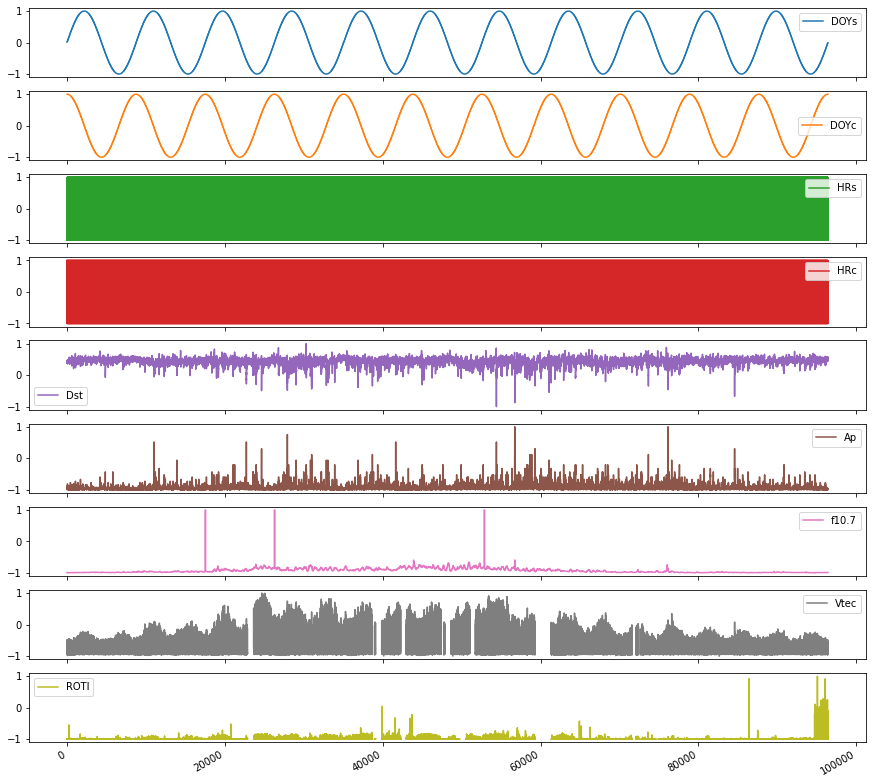

In [ ]:
features_considered = ['DOYs', 'DOYc', 'HRs', 'HRc', 'Dst', 'Ap', 'f10.7', 'Vtec', 'ROTI']
features = df[features_considered]
print(features)
features.plot(subplots=True, figsize=(15, 15))

In [ ]:
future_target = 24*1
past_history = 24*8
STEP = 1

train_data = features.drop(test_indices).values
test_data = features.loc[test_indices].values

x_train_multi, y_train_multi = multivariate_data(train_data, train_data[:, -1],
                                                 0, None, past_history,
                                                 future_target, STEP)
x_val_multi, y_val_multi = multivariate_data(test_data, test_data[:, -1],
                                             0, None, past_history,
                                             future_target, STEP)

print(f'Single window of past history : {x_train_multi[0].shape}')
print(f'Target Vtec to predict : {y_train_multi[0].shape}')
print(f"Shape of x_train: {x_train_multi.shape}")
print(f"Shape of x_val: {x_val_multi.shape}")

Single window of past history : (192, 9)
Target Vtec to predict : (24,)
Shape of x_train: (58390, 192, 9)
Shape of x_val: (214, 192, 9)


(1024, 192, 9)


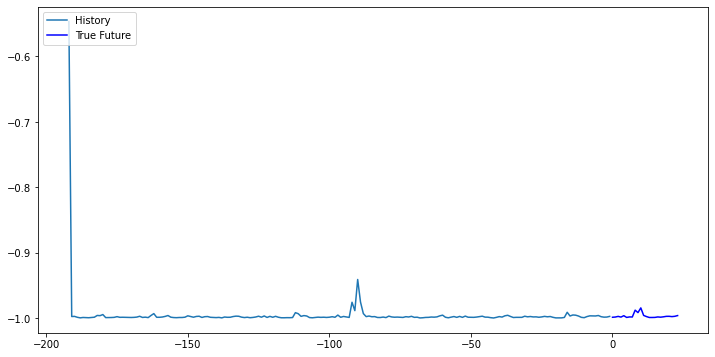

(1024, 192, 9)


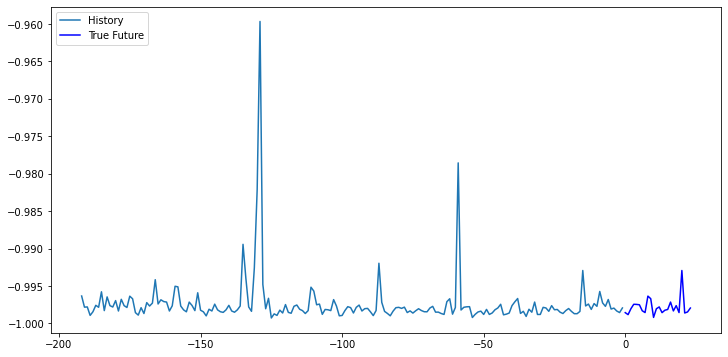

In [ ]:
# BUFFER_SIZE = 10000
BATCH_SIZE = 1024

train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, y_train_multi)).batch(BATCH_SIZE).cache()
# train_data_multi = train_data_multi.cache().shuffle(BUFFER_SIZE).repeat()

val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi)).batch(BATCH_SIZE)
# val_data_multi = val_data_multi.repeat()

for x, y in train_data_multi.take(2):
  
  print(x.shape)
  multi_step_plot(x[0], y[0], np.array([0]))

In [ ]:
multi_step_model = tf.keras.models.Sequential()
multi_step_model.add(tf.keras.layers.LSTM(64,
                                          return_sequences=True,
                                          input_shape=x_train_multi.shape[-2:]))
multi_step_model.add(tf.keras.layers.LSTM(256, activation='relu', return_sequences=True))
multi_step_model.add(tf.keras.layers.LSTM(256, activation='relu', return_sequences=True))
multi_step_model.add(tf.keras.layers.LSTM(64, activation='relu'))
multi_step_model.add(tf.keras.layers.Dense(future_target))

multi_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(clipvalue=1.0), loss='mae')

for x, y in val_data_multi.take(1):
  print(x.shape)
  print (multi_step_model.predict(x).shape)

(214, 192, 9)
(214, 24)


In [ ]:
EPOCHS = 80
EVALUATION_INTERVAL = None 


class CustomSaver(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        self.model.save(project_path + f"big_roti_model2_{epoch}.h5")
saver = CustomSaver()

multi_step_history = multi_step_model.fit(train_data_multi, epochs=EPOCHS,
                                          steps_per_epoch=EVALUATION_INTERVAL,
                                          validation_data=val_data_multi,
                                          callbacks=[saver])

plot_train_history(multi_step_history, 'Multi-Step Training and validation loss')
multi_step_model.save(project_path+'big_roti_model2.h5')

from tensorflow.keras.models import load_model

multi_step_model_loaded = load_model(project_path+'big_roti_model2.h5')
for x, y in val_data_multi.take(5):
  pred = multi_step_model.predict(x)[2]
  multi_step_plot(x[2], y[2], pred)
  multi_step_plot(x[3], y[3], pred)

Epoch 1/80


KeyboardInterrupt: ignored

In [ ]:
from tensorflow.keras.models import load_model

multi_step_model_loaded = load_model(project_path+'big_roti_model2_79.h5')
for x, y in val_data_multi.take(10):
  pred = multi_step_model_loaded.predict(x)[2]
  print(x.shape)
  print(y.shape)
  print(pred.shape)
  multi_step_plot(x[0], y[0], pred)
  multi_step_plot(x[1], y[1], pred)
  multi_step_plot(x[2], y[2], pred)
  multi_step_plot(x[3], y[3], pred)

In [ ]:
for data in val_data_multi:
  print(type(data[0]), type(data[1]))
  print(data[0].shape, data[1].shape)
  break

<class 'tensorflow.python.framework.ops.EagerTensor'> <class 'tensorflow.python.framework.ops.EagerTensor'>
(214, 192, 9) (214, 24)


In [ ]:
for x, y in val_data_multi.take(2):
  pred = multi_step_model_loaded.predict(x)[2]
  print(x.shape)
  print(y.shape)
  print(pred.shape)
  multi_step_plot(x[0], y[0], pred)
  multi_step_plot(x[1], y[1], pred)
  multi_step_plot(x[2], y[2], pred)
  multi_step_plot(x[3], y[3], pred)

In [ ]:
results_path = '/content/drive/My Drive/GNSS/Prediction/Results'

In [ ]:
def multi_step_plot(history, true_future, prediction,axs, i):
  """Plots true timeseries along with predicted"""

  num_in = create_time_steps(len(history))
  num_out = len(true_future)

  axs[i].plot(num_in, np.array(history[:, -1]), label='History')
  axs[i].plot(np.arange(num_out)/STEP, np.array(true_future), 'b-',
           label='True Future')
  if prediction.any():
    axs[i].plot(np.arange(num_out)/STEP, np.array(prediction), 'r-',
             label='Predicted Future')
  axs[i].legend(loc='upper left')
  #fig.savefig(os.path.join(results_path, str(i)+'.png'))

  #plt.show()

(214, 192, 9)
(214, 24)
(24,)


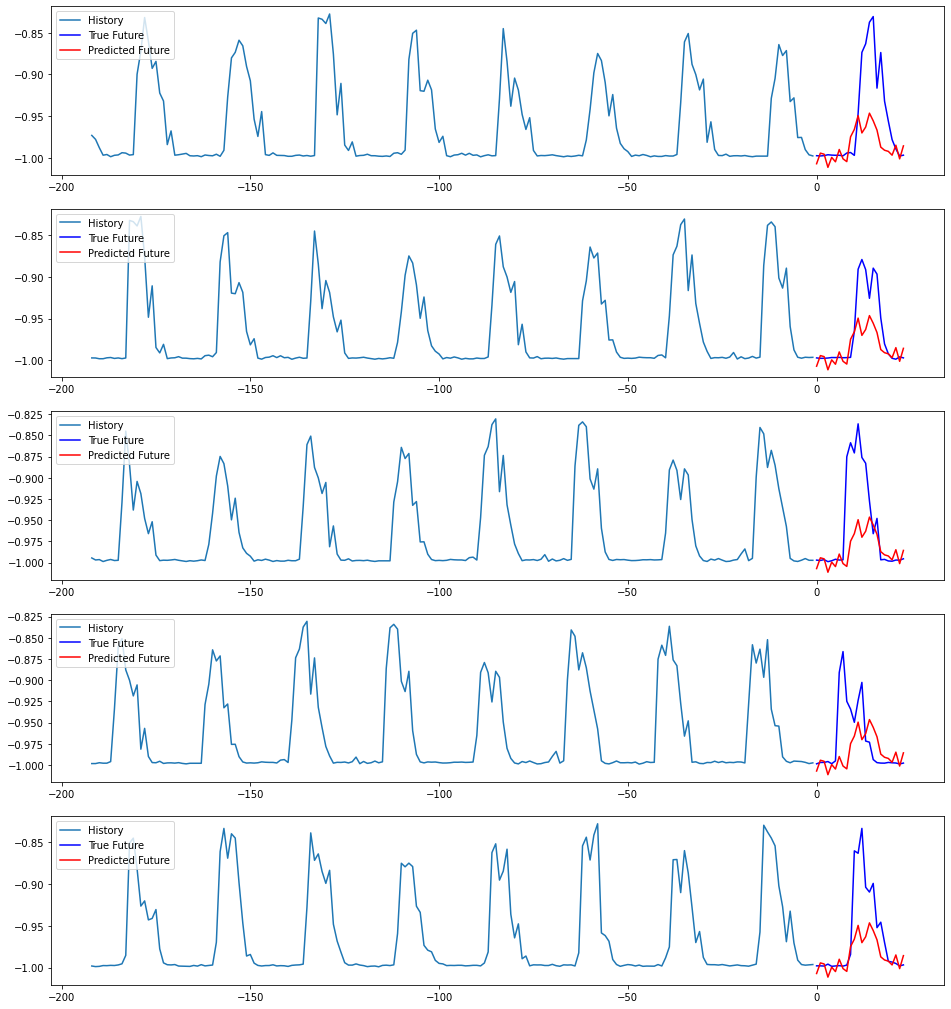

In [ ]:
fig, axs = plt.subplots(5, figsize=(16, 18))


for (x, y) in val_data_multi.take(42):
  pred = multi_step_model_loaded.predict(x)[2]
  print(x.shape)
  print(y.shape)
  print(pred.shape)
  multi_step_plot(x[0], y[0], pred, axs, 0)
  multi_step_plot(x[50], y[50], pred, axs, 1)
  multi_step_plot(x[100], y[100], pred, axs, 2)
  multi_step_plot(x[150], y[150], pred, axs, 3)
  multi_step_plot(x[200], y[200], pred, axs, 4)
  
fig.savefig(os.path.join(results_path, 'Results.png'))

(214, 192, 9)
(214, 24)


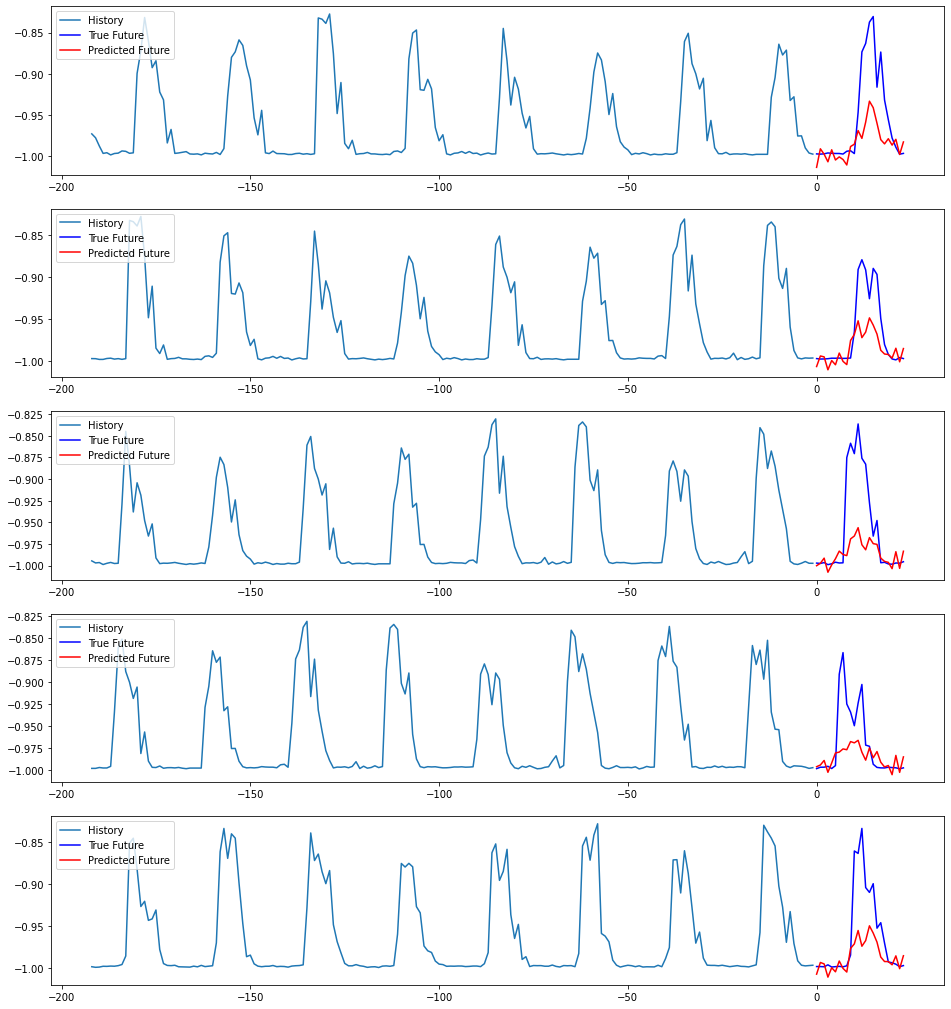

In [ ]:
fig, axs = plt.subplots(5, figsize=(16, 18))


for (x, y) in val_data_multi.take(42):
  # pred = multi_step_model_loaded.predict(x)[2]
  print(x.shape)
  print(y.shape)
  #print(pred.shape)
  pred = multi_step_model_loaded.predict(x)[0]
  multi_step_plot(x[0], y[0], pred, axs, 0)
  pred = multi_step_model_loaded.predict(x)[50]
  multi_step_plot(x[50], y[50], pred, axs, 1)
  pred = multi_step_model_loaded.predict(x)[100]
  multi_step_plot(x[100], y[100], pred, axs, 2)
  pred = multi_step_model_loaded.predict(x)[150]
  multi_step_plot(x[150], y[150], pred, axs, 3)
  pred = multi_step_model_loaded.predict(x)[200]
  multi_step_plot(x[200], y[200], pred, axs, 4)
  
fig.savefig(os.path.join(results_path, 'Results.png'))

**--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------**

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import tensorflow as tf
tf.random.set_seed(13)
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

# Get data

from google.colab import drive
drive.mount('/gdrive')
project_path = '/gdrive/My Drive/GNSS/'
train_df = pd.read_csv(project_path + 'data/dataset_IISC_2009_2018.csv') 
test_df = pd.read_csv(project_path + 'data/dataset_IISC_2019_only.csv')
df = train_df.append(test_df, ignore_index=True)

# Consider only certain features and make DOY and HR continous using sin and cos

input_df = df[['Year','DOY','HR','Dst','Ap','f10.7','Vtec', 'ROTI']]
input_df['DOYs'] = np.sin((2*np.pi*input_df['DOY'].values)/365.25)
input_df['DOYc'] = np.cos((2*np.pi*input_df['DOY'].values)/365.25)
input_df['HRs'] = np.sin((2*np.pi*input_df['HR'].values)/24)
input_df['HRc'] = np.cos((2*np.pi*input_df['HR'].values)/24)
input_df_features = input_df[['DOYs', 'DOYc', 'HRs', 'HRc', 'Dst', 'Ap', 'f10.7', 'Vtec', 'ROTI']]
input_df_years = input_df['Year']


# scale features
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(-1, 1))
input_df_features_scaled = pd.DataFrame(scaler.fit_transform(input_df_features), columns=input_df_features.columns)
input_df_features_scaled['Year'] = input_df_years
input_df = input_df_features_scaled[['Year', 'DOYs', 'DOYc', 'HRs', 'HRc', 'Dst', 'Ap', 'f10.7', 'Vtec', 'ROTI']]
df = input_df.drop(columns=['Year'])

test_indices = list(input_df[input_df['Year'] == 2014].index)[54*24:100*24] # Get indices for 55th to 100th day in 2014

N = len(df)


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

In [3]:
df.head()

,DOYs,DOYc,HRs,HRc,Dst,Ap,f10.7,Vtec,ROTI
0,0.017209,0.999861,0.000000,1.000000,0.440000,-0.949153,-0.993166,-0.961946,-0.998437
1,0.017209,0.999861,0.258819,0.965926,0.453333,-0.949153,-0.993166,-0.876859,-0.998726
2,0.017209,0.999861,0.500000,0.866025,0.460000,-0.949153,-0.993166,-0.772374,-0.998278
3,0.017209,0.999861,0.707107,0.707107,0.453333,-0.923729,-0.993166,-0.717364,-0.998341
4,0.017209,0.999861,0.866025,0.500000,0.440000,-0.923729,-0.993166,-0.688455,-0.997542


In [21]:
df.corr()

,DOYs,DOYc,HRs,HRc,Dst,Ap,f10.7,Vtec,ROTI
DOYs,1.000000e+00,4.013916e-06,-4.475618e-18,1.618034e-18,0.031462,-0.011952,-6.464702e-03,0.030303,-0.021194
DOYc,4.013916e-06,1.000000e+00,4.142587e-18,2.017741e-18,0.014318,-0.041287,5.022041e-02,0.047407,0.086586
HRs,-4.475618e-18,4.142587e-18,1.000000e+00,-3.700628e-17,-0.015213,-0.011079,3.155538e-18,0.560568,-0.120461
HRc,1.618034e-18,2.017741e-18,-3.700628e-17,1.000000e+00,-0.011839,0.058300,-1.898354e-18,-0.521947,-0.093870
Dst,3.146239e-02,1.431806e-02,-1.521333e-02,-1.183913e-02,1.000000,-0.575110,-1.256014e-01,-0.143156,0.007261
Ap,-1.195232e-02,-4.128728e-02,-1.107940e-02,5.830003e-02,-0.575110,1.000000,6.030718e-02,0.037881,-0.014936
f10.7,-6.464702e-03,5.022041e-02,3.155538e-18,-1.898354e-18,-0.125601,0.060307,1.000000e+00,0.331264,0.021837
Vtec,3.030306e-02,4.740704e-02,5.605681e-01,-5.219468e-01,-0.143156,0.037881,3.312641e-01,1.000000,-0.010084
ROTI,-2.119429e-02,8.658582e-02,-1.204612e-01,-9.387047e-02,0.007261,-0.014936,2.183671e-02,-0.010084,1.000000


In [7]:
class Net(nn.Module):
  def __init__(self, hidden=256, channels=8):
    super(Net, self).__init__()
    self.fc1 = nn.Linear(channels, hidden)
    self.fc2 = nn.Linear(hidden, hidden)
    self.fc3 = nn.Linear(hidden, 1)

  def forward(self, x):
    out = self.fc1(x)
    out = self.fc2(out)
    out = self.fc3(out)

    return out

# **VTEC FF**

In [39]:
data = torch.Tensor(df.iloc[: , :-1].dropna().values)
label = torch.Tensor(df.iloc[: , -2].dropna().values)
data.shape, label.shape

(torch.Size([85705, 8]), torch.Size([85705]))

In [40]:
#Offset data


train_fraction = 0.8
train_data = data[:int(data.shape[0] * train_fraction) - 1 , :]
test_data = data[int(data.shape[0] * train_fraction):-1 , :]
train_label = label[1:int(data.shape[0] * train_fraction)]
test_label = label[int(data.shape[0] * train_fraction)+1:]
train_data.shape, test_data.shape, train_label.shape, test_label.shape

(torch.Size([68563, 8]),
 torch.Size([17140, 8]),
 torch.Size([68563]),
 torch.Size([17140]))

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
model = Net(1024).to(device)
lr = 0.01
opt = torch.optim.SGD(model.parameters(), lr, 0.9)
loss_fn = nn.MSELoss()
epochs = 100
bs = 24

In [ ]:
loss_arr = []

for e in range(epochs):
  start = 0
  epoch_loss = 0
  for _ in range(train_data.shape[0]//bs):
    try:
      data = train_data[start:start + bs , :]
      label = train_label[start:start + bs]
    except:
      data = train_data[start: , :]
      label = train_label[start:]
    data = data.to(device)
    label = label.view(-1, 1).to(device)
    start += bs

    opt.zero_grad()
    out = model(data)
    loss = loss_fn(out, label)
    loss.backward()
    opt.step()

    epoch_loss += loss.item()
  
  loss_arr.append(epoch_loss)
  print(f'Epoch {e+1}: Loss = {epoch_loss}')

plt.plot(loss_arr)


In [ ]:
torch.save(model.state_dict(), '/gdrive/My Drive/GNSS/models/ff_vtec_1024.pt')

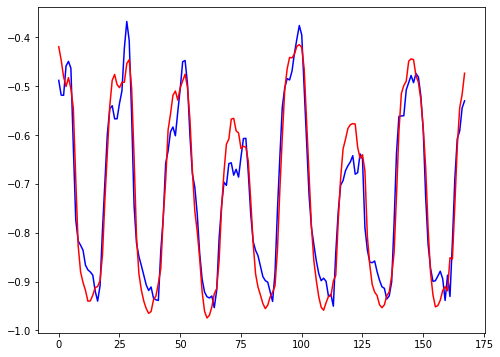

In [52]:
fig, axs = plt.subplots(1)
axs.plot(test_label[:24*7], 'b')
axs.plot(model(test_data[:24*7 , :].to(device)).detach().cpu().numpy(), 'r')


In [ ]:
torch.save(model.state_dict(), '/gdrive/My Drive/GNSS/models/ff_vtec_1024.pt')

In [16]:
model = Net(256).to(device)
model.load_state_dict(torch.load('/gdrive/My Drive/GNSS/models/ff_vtec.pt'))

<All keys matched successfully>

In [41]:
model = Net(1024).to(device)
model.load_state_dict(torch.load('/gdrive/My Drive/GNSS/models/ff_vtec_1024.pt'))

<All keys matched successfully>

In [49]:
24*365

8760

In [47]:
from sklearn.metrics import r2_score
r2_score(test_label[-8760:], model(test_data[-8760: , :].to(device)).detach().cpu().numpy())

0.9391624124084726

In [19]:
from sklearn.metrics import r2_score
r2_score(test_label, model(test_data.to(device)).detach().cpu().numpy())

0.9413987010778255

# **ROTI FF**

In [ ]:
data = torch.Tensor(df.iloc[: , :].dropna().values)
label = torch.Tensor(df.iloc[: , -1].dropna().values)
data.shape, label.shape

(torch.Size([84065, 9]), torch.Size([86353]))

In [ ]:
#Offset data


train_fraction = 0.8
train_data = data[:int(data.shape[0] * train_fraction) - 1 , :]
test_data = data[int(data.shape[0] * train_fraction):-1 , :]
train_label = label[1:int(data.shape[0] * train_fraction)]
test_label = label[int(data.shape[0] * train_fraction)+1:]
train_data.shape, test_data.shape, train_label.shape, test_label.shape

(torch.Size([67251, 9]),
 torch.Size([16812, 9]),
 torch.Size([67251]),
 torch.Size([19100]))

In [ ]:
model = Net(hidden=512, channels=9).to(device)
lr = 0.01
opt = torch.optim.SGD(model.parameters(), lr, 0.9)
loss_fn = nn.MSELoss()
epochs = 100
bs = 32

Epoch 1: Loss = 12.641916947938967
Epoch 2: Loss = 2.0758403582987057
Epoch 3: Loss = 2.4026936491642346
Epoch 4: Loss = 1.4623254290320347
Epoch 5: Loss = 1.155848073485231
Epoch 6: Loss = 0.9703226456191487
Epoch 7: Loss = 0.9512273075399094
Epoch 8: Loss = 0.9431990316100496
Epoch 9: Loss = 0.9425669129452672
Epoch 10: Loss = 0.9775921415400148
Epoch 11: Loss = 0.9258991073139669
Epoch 12: Loss = 0.946704599518057
Epoch 13: Loss = 0.962240989640577
Epoch 14: Loss = 0.939640325795267
Epoch 15: Loss = 0.9401635506837636
Epoch 16: Loss = 0.9736285369466486
Epoch 17: Loss = 0.9723073900884742
Epoch 18: Loss = 0.9635631173001684
Epoch 19: Loss = 0.9750160098699325
Epoch 20: Loss = 0.9453437103240958
Epoch 21: Loss = 0.9383949314116649
Epoch 22: Loss = 0.9404760922388391
Epoch 23: Loss = 0.9408841609807723
Epoch 24: Loss = 0.940900011939533
Epoch 25: Loss = 0.9403529933937591
Epoch 26: Loss = 0.9396057838851846
Epoch 27: Loss = 0.9388877992983566
Epoch 28: Loss = 0.9384015555858696
Epoch 

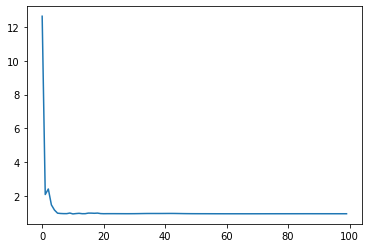

In [ ]:
loss_arr = []

for e in range(epochs):
  start = 0
  epoch_loss = 0
  for _ in range(train_data.shape[0]//bs):
    try:
      data = train_data[start:start + bs , :]
      label = train_label[start:start + bs]
    except:
      data = train_data[start: , :]
      label = train_label[start:]
    data = data.to(device)
    label = label.view(-1, 1).to(device)
    start += bs

    opt.zero_grad()
    out = model(data)
    loss = loss_fn(out, label)
    loss.backward()
    opt.step()

    epoch_loss += loss.item()
  
  loss_arr.append(epoch_loss)
  print(f'Epoch {e+1}: Loss = {epoch_loss}')

plt.plot(loss_arr)


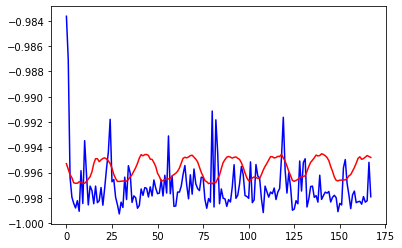

In [ ]:
fig, axs = plt.subplots(1)
axs.plot(test_label[:24*7], 'b')
axs.plot(model(test_data[:24*7 , :].to(device)).detach().numpy(), 'r')


# **VTEC 1D Conv**

In [ ]:
data = torch.Tensor(df.iloc[: , :-1].dropna().values)
label = torch.Tensor(df.iloc[: , -2].dropna().values)
data.shape, label.shape

(torch.Size([85705, 8]), torch.Size([85705]))

In [ ]:
#Offset data


train_fraction = 0.8
train_data = data[:int(data.shape[0] * train_fraction) - 1 , :]
test_data = data[int(data.shape[0] * train_fraction):-1 , :]
train_label = label[1:int(data.shape[0] * train_fraction)]
test_label = label[int(data.shape[0] * train_fraction)+1:]
train_data.shape, test_data.shape, train_label.shape, test_label.shape

(torch.Size([68563, 8]),
 torch.Size([17140, 8]),
 torch.Size([68563]),
 torch.Size([17140]))

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
class Conv1D(nn.Module):
  def __init__(self, hidden=256, channels=8, bs=24*7):
    super(Conv1D, self).__init__()
    self.conv1 = nn.Conv1d(1, 3, 3, 1)
   # self.conv2 = nn.Conv1d(3, 6, 3, 1)
    self.fc1 = nn.Linear(3024, hidden)
    self.fc2 = nn.Linear(hidden, hidden)
    self.fc3 = nn.Linear(hidden, bs)

  def forward(self, x):
    out = F.relu(self.conv1(x))
    out = out.view(1, -1)
    out = self.fc1(out)
    out = self.fc2(out)
    out = self.fc3(out)




    return out

In [ ]:
model = Conv1D(256).to(device)
lr = 0.01
opt = torch.optim.SGD(model.parameters(), lr, 0.9)
loss_fn = nn.MSELoss()
epochs = 100
bs = 24*7

Epoch 1: Loss = 45.46947690425441
Epoch 2: Loss = 15.839233589358628
Epoch 3: Loss = 15.458317641401663
Epoch 4: Loss = 14.04104138747789
Epoch 5: Loss = 16.791919836308807
Epoch 6: Loss = 14.314962541218847
Epoch 7: Loss = 12.020261655328795
Epoch 8: Loss = 10.982566271326505
Epoch 9: Loss = 10.052762086037546
Epoch 10: Loss = 9.14385819551535
Epoch 11: Loss = 8.329157020431012
Epoch 12: Loss = 7.687344866804779
Epoch 13: Loss = 7.160678675863892
Epoch 14: Loss = 6.772422660258599
Epoch 15: Loss = 6.464962441241369
Epoch 16: Loss = 6.171224632998928
Epoch 17: Loss = 5.878179611987434
Epoch 18: Loss = 5.625369839370251
Epoch 19: Loss = 5.408929703524336
Epoch 20: Loss = 5.199340514023788
Epoch 21: Loss = 4.997480149613693
Epoch 22: Loss = 4.804233584320173
Epoch 23: Loss = 4.628609686740674
Epoch 24: Loss = 4.471408220008016
Epoch 25: Loss = 4.33198577130679
Epoch 26: Loss = 4.2134842267259955
Epoch 27: Loss = 4.094223816064186
Epoch 28: Loss = 3.977147212252021
Epoch 29: Loss = 3.8754

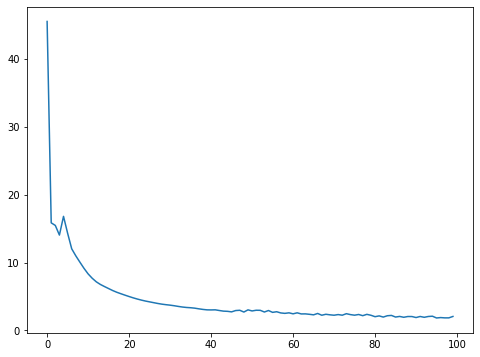

In [ ]:
loss_arr = []

for e in range(epochs):
  start = 0
  epoch_loss = 0
  for _ in range(train_data.shape[0]//bs):
    try:
      data = train_data[start:start + bs , :].view(bs, 1, -1)
      label = train_label[start:start + bs]
    except:
      data = train_data[start: , :].view(bs, 1, -1)
      label = train_label[start:]
    data = data.to(device)
    label = label.view(1, -1).to(device)
    start += bs

    opt.zero_grad()
    out = model(data)

    loss = loss_fn(out, label)
    loss.backward()
    opt.step()

    epoch_loss += loss.item()
  
  loss_arr.append(epoch_loss)
  print(f'Epoch {e+1}: Loss = {epoch_loss}')

plt.plot(loss_arr)


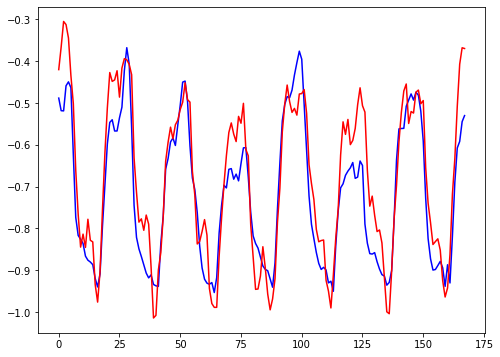

In [ ]:
fig, axs = plt.subplots(1)
axs.plot(test_label[:bs], 'b')
axs.plot(model(test_data[:bs , :].to(device).reshape(bs, 1, -1)).detach().numpy().reshape(bs, ), 'r')

# **VTEC FF Reduced Features**

In [25]:
data = torch.Tensor(df.iloc[: , :-1].drop(['Dst', 'Ap'], axis=1).dropna().values)
label = torch.Tensor(df.iloc[: , -2].dropna().values)
data.shape, label.shape

(torch.Size([85705, 6]), torch.Size([85705]))

In [26]:
#Offset data


train_fraction = 0.8
train_data = data[:int(data.shape[0] * train_fraction) - 1 , :]
test_data = data[int(data.shape[0] * train_fraction):-1 , :]
train_label = label[1:int(data.shape[0] * train_fraction)]
test_label = label[int(data.shape[0] * train_fraction)+1:]
train_data.shape, test_data.shape, train_label.shape, test_label.shape

(torch.Size([68563, 6]),
 torch.Size([17140, 6]),
 torch.Size([68563]),
 torch.Size([17140]))

In [27]:
model = Net(channels=6, hidden=1024).to(device)
lr = 0.01
opt = torch.optim.SGD(model.parameters(), lr, 0.9)
loss_fn = nn.MSELoss()
epochs = 100
bs = 24

Epoch 1: Loss = 15.187589089939138
Epoch 2: Loss = 15.057716462324606
Epoch 3: Loss = 15.058656601438997
Epoch 4: Loss = 15.049650262109935
Epoch 5: Loss = 15.031608114557457
Epoch 6: Loss = 15.012543750926852
Epoch 7: Loss = 15.002403237682302
Epoch 8: Loss = 15.00624589502695
Epoch 9: Loss = 15.022859363612952
Epoch 10: Loss = 15.045465607196093
Epoch 11: Loss = 15.063058532949071
Epoch 12: Loss = 15.070057954202639
Epoch 13: Loss = 15.072327348781982
Epoch 14: Loss = 15.078951522766147
Epoch 15: Loss = 15.092513269322808
Epoch 16: Loss = 15.110136557123042
Epoch 17: Loss = 15.1276320478064
Epoch 18: Loss = 15.138254286895972
Epoch 19: Loss = 15.132383906078758
Epoch 20: Loss = 15.103784282924607
Epoch 21: Loss = 15.060316408402286
Epoch 22: Loss = 15.022723359492375
Epoch 23: Loss = 15.017493032384664
Epoch 24: Loss = 15.055878181767184
Epoch 25: Loss = 15.136592801980441
Epoch 26: Loss = 15.254966546199284
Epoch 27: Loss = 15.213063684786903
Epoch 28: Loss = 15.045322863850743
Epoc

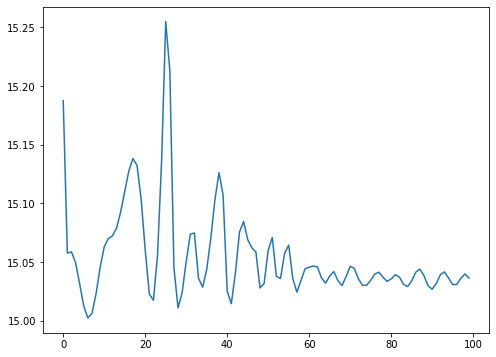

In [32]:
loss_arr = []

for e in range(epochs):
  start = 0
  epoch_loss = 0
  for _ in range(train_data.shape[0]//bs):
    try:
      data = train_data[start:start + bs , :]
      label = train_label[start:start + bs]
    except:
      data = train_data[start: , :]
      label = train_label[start:]
    data = data.to(device)
    label = label.view(-1, 1).to(device)
    start += bs

    opt.zero_grad()
    out = model(data)
    loss = loss_fn(out, label)
    loss.backward()
    opt.step()

    epoch_loss += loss.item()
  
  loss_arr.append(epoch_loss)
  print(f'Epoch {e+1}: Loss = {epoch_loss}')

plt.plot(loss_arr)


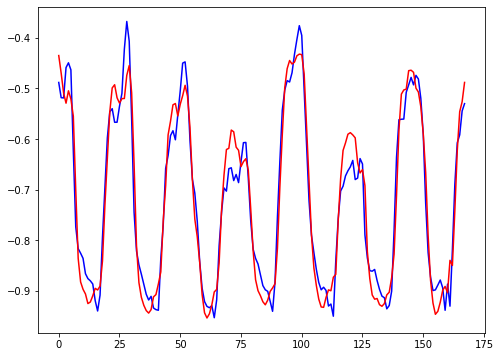

In [33]:
fig, axs = plt.subplots(1)
axs.plot(test_label[:24*7], 'b')
axs.plot(model(test_data[:24*7 , :].to(device)).detach().cpu().numpy(), 'r')


In [43]:
from sklearn.metrics import r2_score
r2_score(test_label, model(test_data.to(device)).detach().cpu().numpy())

0.9413987010778255

In [36]:
torch.save(model.state_dict(), '/gdrive/My Drive/GNSS/models/ff_vtec_reduced_features.pt')